# DeepSensor Quickstart

This notebook demonstrates how to use DeepSensor to train a ConvNP model to spatially interpolate ERA5 air temperature data over North America and use the trained model predict air temperature at arbitrary locations.

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import deepsensor.torch as deepsensor
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.train.train import train_epoch

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

In [2]:
# Load raw data
ds_raw = xr.tutorial.open_dataset("air_temperature")

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...


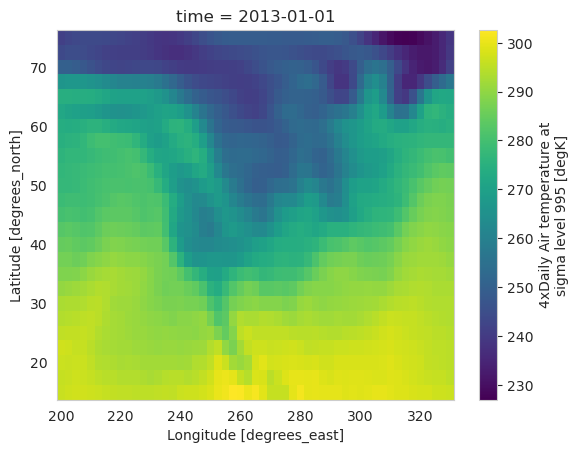

In [3]:
print(ds_raw)
ds_raw.isel(time=0).air.plot()

In [4]:
# Normalise data
data_processor = DataProcessor(x1_name="lat", x1_map=(ds_raw["lat"].min(), ds_raw["lat"].max()), x2_name="lon", x2_map=(ds_raw["lon"].min(), ds_raw["lon"].max()))
ds = data_processor(ds_raw)

In [5]:
# Set up task loader
task_loader = TaskLoader(context=ds, target=ds)

In [6]:
# Set up model
model = ConvNP(data_processor, task_loader, unet_channels=(32,)*8)

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
points_per_unit inferred from TaskLoader: 39
encoder_scales inferred from TaskLoader: [0.015224358066916466]
decoder_scale inferred from TaskLoader: 0.02564102564102564


In [7]:
# Generate training tasks with up to 10% of grid cells passed as context and all grid cells
# passed as targets
train_tasks = []
for date in pd.date_range("2013-01-01", "2014-11-30")[::7]:
    task = task_loader(date, context_sampling=np.random.uniform(0.0, 0.1), target_sampling="all")
    train_tasks.append(task)

In [8]:
from tqdm import tqdm

# Train model
for epoch in tqdm(range(10)):
    losses = train_epoch(model, train_tasks)

100%|████████████████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.13s/it]


In [9]:
# Predict on new task with 40 random grid cells passed as context
test_task = task_loader("2014-12-31", 40)
mean_ds, std_ds = model.predict(test_task, X_t=ds_raw)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.Dataset>
Dimensions:  (time: 1, lat: 25, lon: 53)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Data variables:
    air      (time, lat, lon) float32 246.5 243.5 241.5 ... 296.9 296.5 295.6


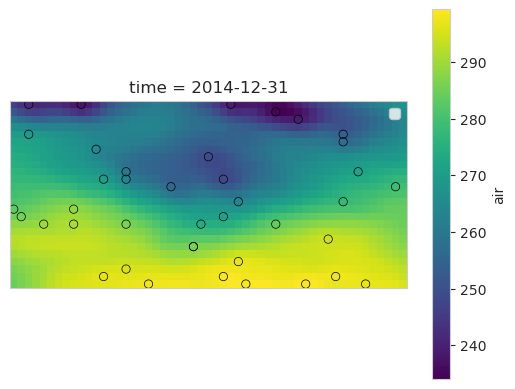

In [10]:
print(mean_ds)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
mean_ds.isel(time=0).air.plot(ax=ax)
deepsensor.plot.offgrid_context(ax, test_task, data_processor, task_loader, linewidths=0.5)

<xarray.Dataset>
Dimensions:  (time: 1, lat: 25, lon: 53)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Data variables:
    air      (time, lat, lon) float32 7.748 7.059 6.868 ... 2.906 3.405 4.009


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


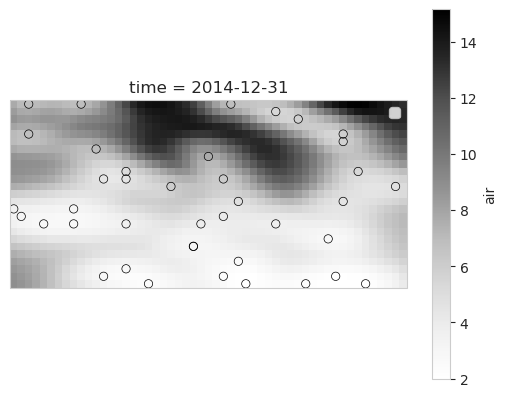

In [11]:
print(std_ds)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
std_ds.isel(time=0).air.plot(cmap='Greys')
deepsensor.plot.offgrid_context(ax, test_task, data_processor, task_loader, linewidths=0.5)

In [69]:
# Predict at New York, San Francisco, and Seattle with 40 random (fixed) context points
X_t = np.array([[40.7128, 360-74.0060], [37.7749, 360-122.4194], [47.6062, 360-122.3321]]).T
test_tasks = task_loader(pd.date_range("2014-12-01", "2014-12-31"), 40, seed_override=42)

In [70]:
mean_df, std_df = model.predict(test_tasks, X_t=X_t, append_indexes={"loc": ["new_york", "san_francisco", "seattle"]})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


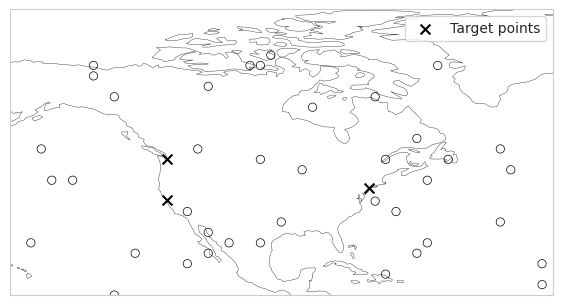

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent([ds_raw["lon"].min(), ds_raw["lon"].max(), ds_raw["lat"].min(), ds_raw["lat"].max()])
ax.coastlines(linewidth=0.25)
deepsensor.plot.offgrid_context(ax, test_tasks[0], data_processor, task_loader, linewidths=0.5)
ax.scatter(X_t[1, :], X_t[0, :], marker="x", color="black", s=50, label="Target points")
ax.legend()
plt.show()

/tmp/ipykernel_20340/3059797121.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


                                                  air
time       lat     lon      loc                      
2014-12-01 40.7128 285.9940 new_york       284.517369
           37.7749 237.5806 san_francisco  283.403134
           47.6062 237.6679 seattle        262.722353
2014-12-02 40.7128 285.9940 new_york       282.410841
           37.7749 237.5806 san_francisco  285.519927
...                                               ...
2014-12-30 37.7749 237.5806 san_francisco  281.859002
           47.6062 237.6679 seattle        259.891275
2014-12-31 40.7128 285.9940 new_york       271.311719
           37.7749 237.5806 san_francisco   277.66355
           47.6062 237.6679 seattle        264.068753

[93 rows x 1 columns]


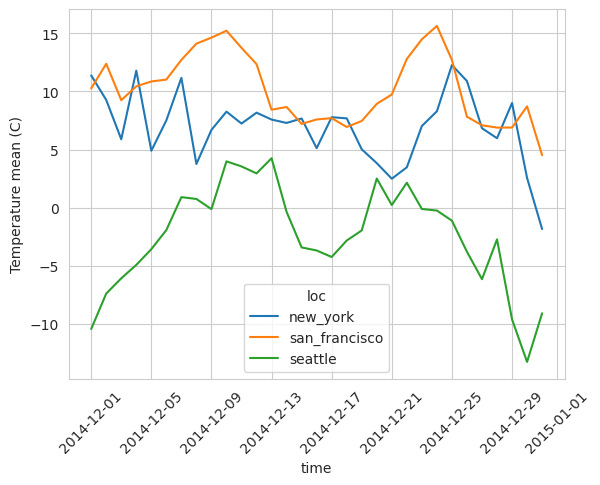

In [72]:
print(mean_df)
ax = sns.lineplot(data=mean_df-273.15, x="time", y="air", hue="loc")
ax.set_ylabel("Temperature mean (C)")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

                                                air
time       lat     lon      loc                    
2014-12-01 40.7128 285.9940 new_york       3.331884
           37.7749 237.5806 san_francisco  4.911497
           47.6062 237.6679 seattle        7.344919
2014-12-02 40.7128 285.9940 new_york       3.434831
           37.7749 237.5806 san_francisco  4.547691
...                                             ...
2014-12-30 37.7749 237.5806 san_francisco    4.7458
           47.6062 237.6679 seattle        7.687726
2014-12-31 40.7128 285.9940 new_york       4.847903
           37.7749 237.5806 san_francisco  5.211041
           47.6062 237.6679 seattle        7.604943

[93 rows x 1 columns]


/tmp/ipykernel_20340/819664832.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


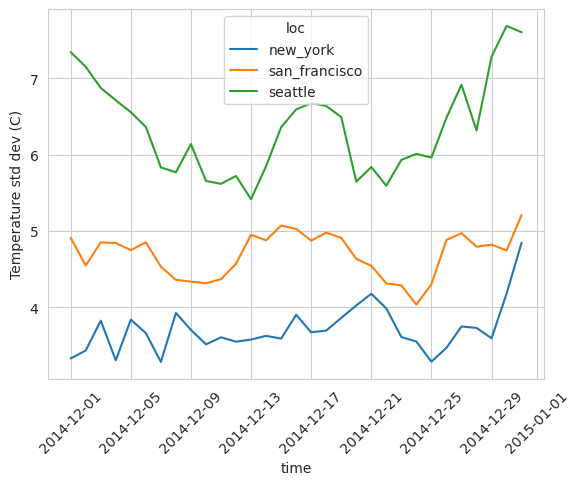

In [73]:
print(std_df)
ax = sns.lineplot(data=std_df, x="time", y="air", hue="loc")
ax.set_ylabel("Temperature std dev (C)")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)